In [7]:
import unicodedata
import string
import re
import random
import time
import datetime
import math
from nltk.tokenize import sent_tokenize, word_tokenize
from io import open
import torchtext.vocab as vocab
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence#, masked_cross_entropy
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from math import floor
%matplotlib inline

USE_CUDA =torch.cuda.is_available()
print('On utilise le GPU, '+str(USE_CUDA)+' story')

#HYPERPARAMETRES TEST
MIN_LENGTH_ARTICLE=10
MIN_LENGTH_SUMMARY=5
MAX_LENGTH_OUTPUT_GENERATE=50
dim=100
glove = vocab.GloVe(name='6B', dim=dim)

#TOKENS
PAD_token = 0
SOS_token = 1
EOS_token = 2
UNK_token = 3

.vector_cache/glove.6B.zip: 0.00B [00:00, ?B/s]

On utilise le GPU, False story


.vector_cache/glove.6B.zip: 862MB [00:29, 29.4MB/s]                           
100%|██████████| 400000/400000 [00:17<00:00, 22806.81it/s]


In [0]:
def get_vocab(scribAPI, vocab_size, pad_token=0, unk_token=3, sos_token=1, eos_token=2):
    """
    get word to index and index to word
    :param scribAPI: ScribAI API object
    :param vocab_size: size of the wanted vocab
    """
    vocab = scribAPI.get_vocab(limit=vocab_size)
    vocab_words = list(map(lambda x: x['word'], vocab))
    vocab_counts = list(map(lambda x: x['count'], vocab))
    word2index = {"PAD":pad_token, "SOS":sos_token,"EOS":eos_token,"UNK": unk_token}
    word2count = {"UNK": 1}
    index2word = {pad_token: "PAD", sos_token: "SOS", eos_token: "EOS", unk_token: "UNK"}
    next_token = max([pad_token, unk_token, sos_token, eos_token]) + 1
    for i, word in enumerate(vocab_words):
        try:
            g = glove.vectors[glove.stoi[word]]
            word2index[word] = next_token
            index2word[next_token] = word
            word2count[word] = vocab_counts[i]
            next_token += 1
        except:
            word2count["UNK"] += 1
    return word2index, word2count, index2word    
    

In [0]:
def get_vect_from_word(word):
    return glove.vectors[glove.stoi[word]]

def tokenize_article_in_words(text_article):
    sentences = [word_tokenize(t) for t in sent_tokenize(text_article)]
    words = []
    for sentence in sentences:
        words.extend(sentence)
    return words

def words_into_vect(words):
    vector = None
    for i, word in enumerate(words):
        if i == 0:
          try:
            vector = get_vect_from_word(word.lower())
          except Exception:
            vector = get_vect_from_word('unk')
        elif i == 1:
          try:
            vector = torch.stack((vector, get_vect_from_word(word.lower())), 1)
          except Exception:
            vector = torch.stack((vector, get_vect_from_word('unk')), 1)
        else:
          try:
            vector = torch.cat((vector, get_vect_from_word(word.lower())), 1)
          except Exception:
            vector = torch.cat((vector, get_vect_from_word('unk')), 1)
    return vector

def create_vocab_from_articles(A):
    word2index = {"PAD":0, "SOS":1,"EOS":2,"UNK": 3}
    word2count = {"UNK": 1}
    index2word = {0: "PAD", 1: "SOS", 2: "EOS", 3: "UNK"}
    n_words = 4  # Count default tokens
    compteur_general=0
    for i, article in enumerate(A):
        words=tokenize_article_in_words(article)
        for word in words:
            compteur_general+=len(words)
            if word not in word2index:
                try:
                    get_vect_from_word(word.lower())
                    word2index[word] = n_words
                    word2count[word] = 1
                    index2word[n_words] = word
                    n_words += 1
                except Exception:
                    word2count["UNK"] += 1
            else:
                word2count[word] += 1
    return word2index, word2count, index2word, compteur_general

def create_ini_embedding(wordtoindex):
    sample=wordtoindex.keys()
    return words_into_vect(sample)

  
def pairs_and_filterpairs(articles,titles,word2index,m,n, seuil=3):
    pairs=[]
    compteur_train=0
    for k, article in enumerate(articles):
        compteur=0
        words=tokenize_article_in_words(article)
        words_target=tokenize_article_in_words(titles[k])
        if len(words) >= m and len(words_target) >= n:
            for word in words:
                try:
                    word2index[word]
                except Exception:
                    compteur=compteur+1
                if word=='UNK':
                    compteur=compteur+1
            for word in words_target:
                try:
                    word2index[word]
                except Exception:
                    compteur=compteur+1
                if word=='UNK':
                    compteur=compteur+1
            if (100*float(compteur)/float(len(words)+len(words_target)))<seuil:
              pairs.append([article,titles[k]])
    return pairs


def indexes_from_sentence(word2index, sentence):
    ind=[]
    for word in sentence.split(' '):
        try:
            ind.append(word2index[word])
        except Exception:
            ind.append(3)
    return ind + [EOS_token]
  
def indexes_from_sentence_target(word2index, sentence,input_seq):
    target_normal=[]
    target_context=[]
    target_pointer=[]
    words_input=input_seq.split(' ')
    for word in sentence.split(' '):
        try:
            target_normal.append(word2index[word])
            target_pointer.append(0)
            target_context.append(0)
        except Exception:
            target_normal.append(UNK_token)
            try:
              index_element = words_input.index(word)
              target_context.append(index_element)
              p=1
            except Exception:
              target_context.append(0)
              p=0
            target_pointer.append(p)
    return target_normal + [EOS_token], target_context +[EOS_token], target_pointer
  
# Pad a with the PAD symbol
def pad_seq(seq, max_length):
    seq += [PAD_token for i in range(max_length - len(seq))]
    return seq
def pad_seq_l(seq, max_length):
    seq += ['PAD' for i in range(max_length - len(seq))]
    return seq

def random_batch(batch_size, pairs,word2index):
    input_seqs = []
    input_seqs_letters=[]
    target_seqs_voc = []
    target_seqs_context = []
    target_seqs_pointer = []
    # Choose random pairs
    for i in range(batch_size):
        pair = random.choice(pairs)
        input_seqs_letters.append(pair[0].split(' '))
        input_seqs.append(indexes_from_sentence(word2index, pair[0]))
        tn,tc,tp=indexes_from_sentence_target(word2index, pair[1],pair[0])
        target_seqs_voc.append(tn)
        target_seqs_context.append(tc)
        target_seqs_pointer.append(tp)
    # Zip into pairs, sort by length (descending), unzip
    seq_pairs = sorted(zip(input_seqs_letters, input_seqs, target_seqs_voc,target_seqs_context, target_seqs_pointer), key=lambda p: len(p[0]), reverse=True)
    input_seqs_letters, input_seqs, target_seqs_voc,target_seqs_context, target_seqs_pointer = zip(*seq_pairs)
    # For input and target sequences, get array of lengths and pad with 0s to max length
    input_lengths = [len(s) for s in input_seqs]
    input_padded = [pad_seq(s, max(input_lengths)) for s in input_seqs]
    target_lengths = [len(s) for s in target_seqs_voc]
    target_padded_voc = [pad_seq(s, max(target_lengths)) for s in target_seqs_voc]
    target_padded_context = [pad_seq(s, max(input_lengths)) for s in target_seqs_context]
    target_padded_pointer = [pad_seq(s, max(target_lengths)) for s in target_seqs_pointer]
    # Turn padded arrays into (batch_size x max_len) tensors, transpose into (max_len x batch_size)
    input_var = Variable(torch.LongTensor(input_padded)).transpose(0, 1)
    target_var_voc = Variable(torch.LongTensor(target_padded_voc)).transpose(0, 1)
    target_var_context= Variable(torch.LongTensor(target_padded_context)).transpose(0, 1)
    target_var_pointer = Variable(torch.LongTensor(target_padded_pointer)).transpose(0, 1)
    
    if USE_CUDA:
        input_var = input_var.cuda()
        target_var_voc = target_var_voc.cuda()
        target_var_context=target_var_context.cuda()
        target_var_pointer=target_var_pointer.cuda()
    
    return input_var, input_lengths, target_var_voc, target_lengths,target_var_context, target_var_pointer,input_seqs_letters

def random_batch_three(batch_size, articles, article_refs, articles2, article_refs2, scores, word2index):
    input_seqs = []
    input_seqs_2 = []
    input_seqs_refs = []
    input_seqs_refs_2 = []
    target_seqs = []
    # Choose random pairs
    for i in range(batch_size):
        k = random.randint(0, len(articles)-1)
        article, article_ref = indexes_from_sentence(word2index, articles[k]), indexes_from_sentence(word2index, article_refs[k])
        article2, article_ref2 = indexes_from_sentence(word2index, articles2[k]), indexes_from_sentence(word2index, article_refs2[k])
        input_seqs.append(article)
        input_seqs_2.append(article2)
        input_seqs_refs.append(article_ref)
        input_seqs_refs_2.append(article_ref2)
        target_seqs.append(scores[k])
    # Zip into pairs, sort by length (descending), unzip
    order_batches1 = [k for k in range(len(input_seqs))]
    order_batches2 = [k for k in range(len(input_seqs_2))]
    seqs1 = sorted(zip(input_seqs, input_seqs_refs, order_batches1), key=lambda p: len(p[0]) + len(p[1]), reverse=True)
    seqs2 = sorted(zip(input_seqs_2, input_seqs_refs_2, order_batches2), key=lambda p: len(p[0]) + len(p[1]), reverse=True)
    input_seqs, input_seqs_refs, order_batches1 = zip(*seqs1)
    input_seqs_2, input_seqs_refs_2, order_batches2 = zip(*seqs2)
    input_lengths = [len(s) for s in input_seqs]
    input_lengths_2 = [len(s) for s in input_seqs_2]
    input_seqs = [pad_seq(s, max(input_lengths)) for s in input_seqs]
    input_seqs_2 = [pad_seq(s, max(input_lengths_2)) for s in input_seqs_2]
    input_seqs_refs_length = [len(s) for s in input_seqs_refs]
    input_seqs_refs_length_2 = [len(s) for s in input_seqs_refs_2]
    input_seqs_refs = [pad_seq(s, max(input_seqs_refs_length)) for s in input_seqs_refs]
    input_seqs_refs_2 = [pad_seq(s, max(input_seqs_refs_length_2)) for s in input_seqs_refs_2]
    target_seqs = list(target_seqs)

    return input_seqs, input_lengths, input_seqs_refs, input_seqs_refs_length, order_batches1, input_seqs_2, input_lengths_2, input_seqs_refs_2, input_seqs_refs_length_2, order_batches2, target_seqs



In [10]:
print("Charge Vocab & pretrain embedding")
wordtoindex, wordtocount, indextoword = get_vocab(scribAPI, 10000)
pretrained_weight=create_ini_embedding(wordtoindex).transpose(0,1)


Charge Vocab & pretrain embedding


In [11]:
print("Charge Batch")
articles, titles = cnn_dataset.get_batch(batch_size=30)

Charge Batch


Exemples :

In [12]:
print('Lexique of %d words' % len(indextoword))
print("Create pairs")
pairs_train=pairs_and_filterpairs(articles,titles,wordtoindex, MIN_LENGTH_ARTICLE,MIN_LENGTH_SUMMARY, seuil=10)
print('%d pairs' % len(pairs_train))
articles_finals=[]
for i in pairs_train:
  articles_finals.append(i[0])
wti, wtc, itw, c=create_vocab_from_articles(articles_finals)
print(c)
print('%d tokens "UNK", represent %.4f ' % (wtc["UNK"], float(wtc["UNK"])/float(c)))
#random_batch(50, pairs_train, wordtoindex)

Lexique of 9976 words
Create pairs
27 pairs
27346719
121 tokens "UNK", represent 0.0000 


# Sequence to Sequence Model

In [0]:
class EncoderRNN(nn.Module):
  
    def __init__(self, input_size, embed_size, hidden_size,pretrained_weight, n_layers=1, dropout=0.5):
        super(EncoderRNN, self).__init__()
        """
        :param input_size
        :param embed_size
        :param hidden_size
        :param pretrained_weight
        :param n_layers
        :param dropout
        """
        # Define parameters
        self.input_size = input_size  # V Taille Vocabulary (can be different, here not)
        self.hidden_size = hidden_size  # H
        self.embed_size = embed_size  # E
        self.n_layers = n_layers  # L (1 per default)
        self.dropout = dropout  # 0.5 per default
        # Define layers
        self.embedding = nn.Embedding(input_size, embed_size)  # Init (V,E)
        self.embedding.weight = nn.Parameter(pretrained_weight) #Init with glove
        self.embedding = nn.Embedding(input_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size, n_layers, dropout=self.dropout,
                          bidirectional=True)  # Init (E,H,L, Bidirectionnel!)

    def forward(self, input_seqs, input_lengths, hidden=None):
        """
        :param input_seqs:
            Variable of shape (T,B), T is the number of words in the longuest sentence, B is Batchsize. Contening the indexing of the words reference to the voc
        :param input_lengths:
            list of integers (len=B) which reprensents the number of words in sequence for each batch. Normally Max(input_lengths)=T
        :param hidden:
            initial state of GRU
        :returns:
            GRU outputs in shape (T,B,H)
            last hidden stat of RNN(L*bidirectionnal,B,H)
        """
        embedded = self.embedding(input_seqs)  # (T,B,E)
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded,input_lengths)  # cf doc pytorch : take embedding and input_length. Ready to go
        outputs, hidden = self.gru(packed, hidden)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs)  # unpack (back to padded)
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, :, self.hidden_size:]  # Sum bidirectional outputs
        
        return outputs, hidden  # (T,B,H),(L*bidirectionnal,B,H) | bidirectionnal=2 here


In [0]:
class Attn(nn.Module):
    
    def __init__(self, method, hidden_size, temporal=False):
        super(Attn, self).__init__()
        """
        :param method
        :param hidden_size
        :param temporal
        """
        # Define parameters
        self.method = method  # 2 methods cf publi
        self.hidden_size = hidden_size  # H
        self.temporal = temporal  # Temporal attention encoder
        self.softmax = nn.Softmax()
        # Define layers
        self.attn = nn.Linear(self.hidden_size * 2, hidden_size)  # Init(2*H,H)
        self.v = nn.Parameter(torch.rand(hidden_size))
        stdv = 1. / math.sqrt(self.v.size(0))
        self.v.data.normal_(mean=0, std=stdv)


    def forward(self, hidden, encoder_outputs, E_history=None):
        """
        :param hidden:
            (B,H)
        :param encoder_outputs:
            (T,B,H) can be also hidden decoder accumulation over time (t+1,B,H), depends on attention encoder or decoder
        :param E_history:
           Encoder history use only if intra temporal attention. Init with None, then (t,B,T)
        :returns:
            attn_energies which is alpha
        """
        max_len = encoder_outputs.size(0)
        this_batch_size = encoder_outputs.size(1)
        H = hidden.repeat(max_len, 1, 1).transpose(0, 1)
        encoder_outputs = encoder_outputs.transpose(0, 1)  # [B*T*H]
        attn_energies = self.score(H, encoder_outputs)
        if self.temporal:
            if E_history is None:
                E_history = attn_energies.unsqueeze(0)
            else:
                E_history = torch.cat([E_history, attn_energies.unsqueeze(0)], 0)
                hist = E_history.view(-1, this_batch_size * max_len).t()
                attn_energies = self.softmax(hist)[:, -1].contiguous().view(this_batch_size, max_len)
            return F.softmax(attn_energies).unsqueeze(1), E_history
        else:
          # Normalize energies to weights in range 0 to 1, resize to 1 x B x S
          return F.softmax(attn_energies).unsqueeze(1)

    def score(self, hidden, encoder_output):
        """
        :param hidden
        :param encoder_output
        """
        if self.method == 'dot':
            energy = hidden.dot(encoder_output)
            return energy
        elif self.method == 'general':
            energy = self.attn(encoder_output)
            energy = hidden.dot(energy)
            return energy
        elif self.method == 'concat':
            input=torch.cat([hidden, encoder_output], 2)
            energy = F.tanh(self.attn(input))  # [B*T*2H]->[B*T*H]
            energy = energy.transpose(2, 1)  # [B*H*T]
            v = self.v.repeat(encoder_output.data.shape[0], 1).unsqueeze(1)  # [B*1*H]
            energy = torch.bmm(v, energy)  # [B*1*T]
            return energy.squeeze(1)  # [B*T]

In [0]:
class DecoderStep(nn.Module):

    def __init__(self, hidden_size, embed_size, output_size, n_layers, temporal=True, de_att_bol=True, point_bol=True, attention_bol=True, dropout_p=0.1):
        super(DecoderStep, self).__init__()
        """
        :param hidden_size
        :param embed_size
        :param output_size
        :param n_layers
        :param temporal
        :param de_att_bol
        :param point_bol
        :param attention_bol
        :param dropout_p   
        """
        # Define parameters
        self.hidden_size = hidden_size  # H
        self.output_size = output_size  # V
        self.n_layers = n_layers  # L
        self.dropout_p = dropout_p  # 0.1 per default
        self.temporal = temporal  # bolean to use intra temporal attention on input sequence cf. Temporal attention model for neural machine translation. arXiv preprint arXiv:1608.02927, 2016
        self.decoder_attention_bolean = de_att_bol  # bolean to use intra decoder attention
        self.pointer_boloan = point_bol
        self.attention_bolean=attention_bol
        self.embed_size=embed_size
        # Define layers
        self.embedding = nn.Embedding(output_size, embed_size) # Init(V,E)
        self.dropout = nn.Dropout(dropout_p)
        if self.attention_bolean:
          self.attn_encoder = Attn('concat', hidden_size, temporal) # Init(methode score, H, bolean temporal), cf class
          if self.decoder_attention_bolean:
            self.attn_decoder = Attn('concat', hidden_size, temporal=False)
            self.gru = nn.GRU(2*hidden_size + embed_size, hidden_size, n_layers, dropout=dropout_p)# init(3*H+E,H,L) 
            self.out = nn.Linear(hidden_size * 3, output_size)  # Wout(3H,V) case [1] and [2]
            self.out_proba = nn.Linear(hidden_size * 3, 1)
          else:
            self.gru = nn.GRU(hidden_size + embed_size, hidden_size, n_layers, dropout=dropout_p)# init(2*H+E,H,L) 
            self.out = nn.Linear(hidden_size * 2, output_size)  # Wout(2H,V) case [1] and [2]
            self.out_proba = nn.Linear(hidden_size * 2, 1)
        else:
          self.gru = nn.GRU(embed_size, hidden_size, n_layers, dropout=dropout_p)# init(E,H,L) 
          self.out = nn.Linear(hidden_size, output_size)  # Wout(H,V) case [1] and [2]
        
    def forward(self, word_input, last_hidden, encoder_outputs,E_hist,t, hd_history, input_batches):
        """
        :param word_input:
            tensor with SOS_Token length B
        :param last_hidden:
            Last hidden of the decoder, initialization with last hidden encoder (L,B,H)
        :param encoder_outputs:
            encoder output (T,B,H)
        :param E_hist:
            Encoder history use only if intra temporal attention. Init with None, then (1,B,T)
        :param t:
            number of time generate words [0 to max_length sequence]
        :param hd_history:
            hidden decoder accumulation over time (t+1,B,H)
        :param input_batches:
            input de l'encoder to be able to point to the entry (V,B)
        :returns:
            output decoder : max proba is the word to generate (B,V)
            hidden : will be last hidden next time
            alpha : to plot during the evaluation
            E_history : will be E_hist next time
            hd_history : will be hd_history next time
        """
        # Get the embedding of the current input word (last output word)
        word_embedded = self.embedding(word_input).view(1, word_input.size(0), -1)  # (1,B,E)
        word_embedded = self.dropout(word_embedded)
        if self.attention_bolean:
          # Calculate attention weights -temporal or not- of encoder (alpha) and apply to encoder outputs (context_encoder)
          if self.temporal:
              alpha, E_history = self.attn_encoder(last_hidden[-1], encoder_outputs, E_hist)  # (B,1,T) (1,B,T)
          else:
              E_history = None  # None
              alpha = self.attn_encoder(last_hidden[-1], encoder_outputs)  # (B,1,T) alpha will be use later
          context_encoder = alpha.bmm(encoder_outputs.transpose(0, 1))  # (B,1,H)
          context_encoder = context_encoder.transpose(0, 1)  # (1,B,H) context with the encoder.
          # attention on decoder and RNN input
          if self.decoder_attention_bolean:
              if t:  # Recurrence
                  alpha_d = self.attn_decoder(last_hidden[-1], hd_history)  # (B,1,t)
                  context_decoder = alpha_d.bmm(hd_history.transpose(0, 1))  # (1,B,H)
                  context_decoder = context_decoder.transpose(0, 1)  # (1,H,B)
                  hd_history = torch.cat([hd_history, last_hidden[-1].unsqueeze(0)], dim=0)  # (t+1,B,H)
              else:  # Initialisation
                  context_decoder = Variable(torch.zeros(1, word_embedded.size()[1], self.hidden_size))  # init to zero
                  if USE_CUDA:
                    context_decoder=context_decoder.cuda()
              rnn_input_old = torch.cat((word_embedded, context_encoder), 2)
              rnn_input = torch.cat((rnn_input_old, context_decoder), 2)  # (1,B,H+E+t) idem
          else:
            # Combine embedded input word and attended context, run through RNN
            rnn_input = torch.cat((word_embedded, context_encoder), 2)
        else:
          rnn_input=word_embedded
        #RNN
        output, hidden = self.gru(rnn_input, last_hidden)
        output = output.squeeze(0)  # (1,B,H)->(B,H)
        if self.attention_bolean:
          context_encoder = context_encoder.squeeze(0)
          output_concat=torch.cat((output, context_encoder),1)
          #pointer
          if self.pointer_boloan:
            if self.decoder_attention_bolean:
                context_decoder = context_decoder.squeeze(0)
                output_concat_v2=torch.cat((output_concat, context_decoder),1)
                p_yt_sachant_paspointer = F.log_softmax(self.out(output_concat_v2))
                p_pointer=F.sigmoid(self.out_proba(output_concat_v2))
            else:
                p_yt_sachant_paspointer = F.log_softmax(self.out(output_concat))
                p_pointer=F.sigmoid(self.out_proba(output_concat))
            #Calcul proba finale
            alpha_interet = alpha.squeeze(1)  # (T,B)
            output=[p_yt_sachant_paspointer,alpha_interet, p_pointer]   
          else:
            if self.decoder_attention_bolean:
              context_decoder = context_decoder.squeeze(0)
              output_concat_v2=torch.cat((output_concat, context_decoder),1)
              output = F.log_softmax(self.out(output_concat_v2))
            else:
              output = F.log_softmax(self.out(output_concat))
        else:
            alpha=None
            E_history=None
            output = F.log_softmax(self.out(output))
        
        return output, hidden, alpha, E_history, hd_history
 

# Reward with human feedback

In [0]:
class RewardPredictor(nn.Module):
  
  def __init__(self, input_size, embed_size, hidden_size, indextoword,
                 wordtoindex, num_layer_encoder=1,
                 dropout=0.5, SOS_token=1, EOS_token=2, PAD_token=0, batch_size=5, article_max_size=500):
    super(RewardPredictor, self).__init__()
    """
    :param input_size:
    :param embed_size:
    :param hidden_size:
    :param indextoword:
    :param wordtoindex
    :param num_layer_encoder:
    :param dropout:
    :param SOS_token:
    :param EOS_token:
    :param PAD_token:
    :param batch_size:
    :param article_max_size:
    """
    super(RewardPredictor, self).__init__()
    self.encoder = EncoderRNN(input_size, embed_size, hidden_size,pretrained_weight, n_layers=num_layer_encoder, dropout=dropout)
    
    # conv2d: Hout = floor((Hin−kernel_size[0])/stride[0]+1)
    # Maxpool: Hout = floor((Hin-kernel_size[0])/stride[0]+1)
    
    self.conv1 = nn.Conv2d(1, 8, kernel_size=10, stride=4, padding=0, dilation=1)
    # Max pooling of size 2 kernel_size=2, stride=2, padding=0, dilation=1
    T, H = floor((article_max_size - 10)/4 + 1), floor((2*hidden_size - 10)/4 + 1)
    T, H = floor((T - 2)/2 + 1), floor((H - 2)/2 + 1)
    
    self.conv2 = nn.Conv2d(8, 8, kernel_size=7, stride=3)
    # Max pooling of size 2 kernel_size=2, stride=2, padding=0, dilation=1
    T, H = floor((T-7)/3 + 1), floor((H-7)/3 + 1)
    T, H = floor((T-2)/2 + 1), floor((T-2)/2 + 1)
    
    self.conv3 = nn.Conv2d(8, 8, kernel_size=5, stride=2)
    # Max pooling of size 2 kernel_size=2, stride=2, padding=0, dilation=1
    T, H = floor((T-5)/2 + 1), floor((H-5)/2 + 1)
    # T, H = floor((T-2)/2 + 1), floor((T-2)/2 + 1)  # enlevé car pass assez de dim
    print(2*hidden_size, article_max_size)
    print("size reward", 16*T*H, 50)
    self.out_layer1 = nn.Linear(8 * T * H-8, 50)
    self.out_layer2 = nn.Linear(50, 1)
    
    self.indextoword = indextoword
    self.wordtoindex = wordtoindex
    self.SOS_token = SOS_token
    self.EOS_token = EOS_token
    self.PAD_token = PAD_token
    self.batch_size = batch_size
    self.article_max_size = article_max_size

    if USE_CUDA:
        self.encoder.cuda()
        self.conv1.cuda()
        self.conv2.cuda()
        self.out_layer1.cuda()
        self.out_layer2.cuda()
  
  def forward(self, input_seq_ref, input_seq_ref_length, input_seq, input_seq_length):
    """
    Evaluate the reward function
    :param input_seq_ref: ref sequence (article)
    :param input_seq: summary sequence
    """
    # Run through encoder
    # print(input_seq_ref, input_seq_ref_length)
    input_seq = torch.squeeze(input_seq, 1)
    input_seq_ref = torch.squeeze(input_seq_ref, 1)
    #input_seq_ref = torch.transpose(input_seq_ref, 0, 1)
    #input_seq = torch.transpose(input_seq, 0, 1)

    # print(input_seq_ref)
    encoder_outputs, encoder_hidden = self.encoder(input_seq, input_seq_length, None)
    encoder_ref_outputs, encoder_ref_hidden = self.encoder(input_seq_ref, input_seq_ref_length, None)
    input_metric = F.pad(encoder_outputs, 
                         (0, 0, 0, 0, 0, self.article_max_size - encoder_outputs.size(0)), 
                         "constant", self.PAD_token)
    input_metric_ref = F.pad(encoder_ref_outputs, 
                         (0, 0, 0, 0, 0, self.article_max_size - encoder_ref_outputs.size(0)), 
                         "constant", self.PAD_token)
    input_metric = torch.transpose(input_metric, 0, 1)
    input_metric_ref = torch.transpose(input_metric_ref, 0, 1)
    print("sortie", input_metric)
    compare_vector = torch.cat((input_metric, input_metric_ref), dim=1)
    compare_vector = torch.unsqueeze(compare_vector, 1)  # Add channel dimension
    print("avant")
    print(compare_vector.size())
    compare_vector = F.max_pool2d(F.relu(self.conv1(compare_vector)), 2)
    print("après C1")
    print(compare_vector.size())
    compare_vector = F.max_pool2d(F.relu(self.conv2(compare_vector)), 2)
    print("après C2")
    print(compare_vector.size())
    # compare_vector = F.max_pool2d(F.relu(self.conv3(compare_vector)), 2)
    compare_vector = F.relu(self.conv3(compare_vector))  # Pas de pooling ici, pas assez de dimension apparement
    print("après C3")
    print(compare_vector.size())
    compare_vector = compare_vector.view(self.batch_size, 1, -1)
    print("maitenant")
    print(compare_vector.size())
    compare_vector = self.out_layer1(compare_vector)
    return torch.squeeze(self.out_layer2(compare_vector))

# Training

In [0]:
class Seq2SeqTrainer(nn.Module):
  """
  Model used for the human preferences metric
  """
  def __init__(self, attn_model, hidden_size, embed_size, n_layers, wordtoindex, indextoword,
               n_epochs, encoder_temporal,decoder_attention_bol, pairs_train,
                pointeur_bolean, attention_bolean, tie_weights_bolean, num_layer_encoder=1,
                num_layer_decoder=1,dropout=0.5, SOS_token=1, EOS_token=2, PAD_token=0, batch_size=5,
                clip=50,learning_rate = 0.0001, article_max_size=500, decoder_learning_ratio=5,
                plot_every=20, print_every = 100, evaluate_every = 1000, max_length=100):
    super(Seq2SeqTrainer, self).__init__()
    """
    :param input_size:
    :param embed_size:
    :param hidden_size:
    :param output_size:
    :param indextoword:
    :param wordtoindex
    :param num_layer_encoder:
    :param num_layer_decoder:
    :param dropout:
    :param SOS_token:
    :param EOS_token:
    :param PAD_token:
    :param batch_size:
    :param article_max_size:
    """
    # Configure models
    self.attn_model = attn_model
    self.hidden_size = hidden_size
    self.n_layers = n_layers
    self.dropout = dropout
    self.batch_size = batch_size
    self.embed_size=embed_size
    # Configure training/optimization
    self.clip = clip
    self.learning_rate = learning_rate
    self.decoder_learning_ratio = decoder_learning_ratio
    self.n_epochs = n_epochs
    self.plot_every = plot_every
    self.print_every = print_every
    self.evaluate_every = evaluate_every
    #config type model
    self.encoder_temporal=encoder_temporal
    self.decoder_attention_bol=decoder_attention_bol
    self.pointeur_bolean=pointeur_bolean
    self.attention_bolean=attention_bolean
    self.tie_weights_bolean=tie_weights_bolean
    self.indextoword=indextoword
    self.wordtoindex=wordtoindex
    self.pairs_train=pairs_train
    # Initialize models
    self.encoder = EncoderRNN(len(indextoword), embed_size, hidden_size,pretrained_weight, n_layers=n_layers, dropout=dropout)
    self.decoder = DecoderStep(hidden_size, embed_size,len(indextoword), n_layers, dropout_p=dropout, temporal=encoder_temporal,de_att_bol=decoder_attention_bol,point_bol=pointeur_bolean,attention_bol=attention_bolean )
    self.max_length=max_length
    # Move models to GPU
    if USE_CUDA:
        self.encoder.cuda()
        self.decoder.cuda()


  def train_step(self, input_batches, input_lengths, target_batches, target_lengths, encoder_optimizer, decoder_optimizer, criterion, target_context, target_pointer,E_hist=None):
    """
      
      
      
    """
    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    total_loss = 0 # Added onto for each word
    # Run words through encoder
    encoder_outputs, encoder_hidden = self.encoder(input_batches, input_lengths, None)
    # Share embedding
    self.decoder.embedding.weight = self.encoder.embedding.weight
    # Optionally tie weights as in:
    # "Using the Output Embedding to Improve Language Models" (Press & Wolf 2016)
    if self.tie_weights_bolean:
      # Depend of the configuration you choose, the dimmensions must be : E= H or 2*H ou 3*H
      decoder.out.weight = encoder.embedding.weight
    # Prepare input and output variables
    decoder_input = Variable(torch.LongTensor([SOS_token] * batch_size))
    decoder_hidden = encoder_hidden[:self.decoder.n_layers] # Use last (forward) hidden state from encoder
    max_target_length = max(target_lengths)
    all_decoder_outputs = Variable(torch.zeros(max_target_length, self.batch_size, self.decoder.output_size))
    all_decoder_outputs_context = Variable(torch.zeros(max_target_length, self.batch_size, input_lengths[0]))
    all_decoder_outputs_pointer = Variable(torch.zeros(max_target_length, self.batch_size,1))
    hidden_history_decoder = decoder_hidden[-1].unsqueeze(0)
    # Move new Variables to CUDA
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        all_decoder_outputs = all_decoder_outputs.cuda()
        all_decoder_outputs_context=all_decoder_outputs_context.cuda()
        all_decoder_outputs_pointer=all_decoder_outputs_pointer.cuda()
    # Run through decoder one time step at a time
    for t in range(max_target_length):
        decoder_output, decoder_hidden, decoder_attn, E_hist,hidden_history_decoder = self.decoder(
            decoder_input, decoder_hidden, encoder_outputs,E_hist,t, hidden_history_decoder, input_batches)
        if self.pointeur_bolean:
          all_decoder_outputs[t] = decoder_output[0]
          all_decoder_outputs_context[t] = decoder_output[1]
          all_decoder_outputs_pointer[t] = decoder_output[2]
        else:        
          all_decoder_outputs[t] = decoder_output
        decoder_input = target_batches[t] # Next input is current target
    # Loss calculation and backpropagation
    if self.pointeur_bolean:
      #1er loss : le pointeur
      all_decoder_outputs_pointer=all_decoder_outputs_pointer.squeeze(2)
      loss1=criterion(all_decoder_outputs_pointer,torch.max(target_pointer, 1)[1])
      if 1 in target_pointer.cpu().data.numpy():
        #update tous les poids
        loss2 = masked_cross_entropy(
            all_decoder_outputs.transpose(0, 1).contiguous(), # -> batch x seq
            target_batches.transpose(0, 1).contiguous(), # -> batch x seq
            target_lengths)
        total_loss= sum([loss1,loss2])
      else:
        loss2 = masked_cross_entropy(
            all_decoder_outputs.transpose(0, 1).contiguous(), # -> batch x seq
            target_batches.transpose(0, 1).contiguous(), # -> batch x seq
            target_lengths) 
        #loss sur l'attention en pointer, ca ne va pas tuer l'attention ?
        #loss3 = 
        total_loss= sum([loss1,loss2])
    else:    
      total_loss = masked_cross_entropy(
          all_decoder_outputs.transpose(0, 1).contiguous(), # -> batch x seq
          target_batches.transpose(0, 1).contiguous(), # -> batch x seq
          target_lengths)
    total_loss.backward()
    # Clip gradient norms
    ec = torch.nn.utils.clip_grad_norm(self.encoder.parameters(), self.clip)
    dc = torch.nn.utils.clip_grad_norm(self.decoder.parameters(), self.clip)
    # Update parameters with optimizers
    encoder_optimizer.step()
    decoder_optimizer.step()

    return total_loss.data[0], ec, dc
        
      
  def evaluate(self, input_seq):
    """
    
    
    
    """
    input_lengths = [len(input_seq.split())]
    input_seqs = [indexes_from_sentence(wordtoindex, input_seq)]
    input_batches = Variable(torch.LongTensor(input_seqs), volatile=True).transpose(0, 1)
    words_input=input_seq.split(' ')
    if USE_CUDA:
        input_batches = input_batches.cuda()
    # Set to not-training mode to disable dropout
    self.encoder.train(False)
    self.decoder.train(False)
    # Run through encoder
    encoder_outputs, encoder_hidden = self.encoder(input_batches, input_lengths, None)
    # Share embedding
    self.decoder.embedding.weight = self.encoder.embedding.weight
    # Optionally tie weights as in:
    # "Using the Output Embedding to Improve Language Models" (Press & Wolf 2016)
    if self.tie_weights_bolean:
      # Depend of the configuration you choose, the dimmensions must be : E= H or 2*H ou 3*H
      self.decoder.out.weight = self.encoder.embedding.weight
    # Create starting vectors for decoder
    decoder_input = Variable(torch.LongTensor([SOS_token]), volatile=True) # SOS
    decoder_hidden = encoder_hidden[:self.decoder.n_layers] # Use last (forward) hidden state from encoder
    hidden_history_decoder = decoder_hidden[-1].unsqueeze(0)
    E_hist = None
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
    # Store output words and attention states
    decoded_words = []
    
    decoder_attentions = torch.zeros(max(input_lengths) + 1, max(input_lengths) + 1)
    # Run through decoder
    for di in range(self.max_length):
        decoder_output, decoder_hidden, decoder_attention, E_hist,hidden_history_decoder = self.decoder(
            decoder_input, decoder_hidden, encoder_outputs,E_hist,di, hidden_history_decoder,input_batches
        )
        if self.attention_bolean:
          if self.pointeur_bolean:
            [decoder_output_voc, decoder_output_context, decoder_output_pointer]=decoder_output
            decoder_attentions[di,:decoder_attention.size(2)] += decoder_output_context.squeeze(0).cpu().data
        if self.pointeur_bolean:
          [decoder_output_voc, decoder_output_context, decoder_output_pointer]=decoder_output
          if decoder_output_pointer.cpu().data.numpy()[0][0]>0.5:
            topv, topi = decoder_output_context.data.topk(1)
            ni = topi[0][0]
            topv2, topi2 = decoder_output_context.data.topk(2)
            ni2 = topi2[0][0]
            if len(decoded_words)>=2:
              if decoded_words[-1]==decoded_words[-2]:
                if words_input[ni]==decoded_words[-1]:
                  ni=ni2
            decoded_words.append(words_input[ni])
            try:
              ni=wordtoindex[words_input[ni]]
            except Exception:
              ni=3
            decoder_input = Variable(torch.LongTensor([ni]))
          else:
            topv, topi = decoder_output_voc.data.topk(1)
            ni = topi[0][0]
            topv2, topi2 = decoder_output_context.data.topk(2)
            ni2 = topi2[0][0]
            if ni == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
              if len(decoded_words)>=2:
                if decoded_words[-1]==decoded_words[-2]:
                  if indextoword[ni]==decoded_words[-1]:
                    ni=ni2              
              decoded_words.append(self.indextoword[ni])
              decoder_input = Variable(torch.LongTensor([ni]))
        else:        
          # Choose top word from output
          topv, topi = decoder_output.data.topk(1)
          ni = topi[0][0]
          topv2, topi2 = decoder_output.data.topk(2)
          ni2 = topi2[0][0]
          if ni == EOS_token:
              decoded_words.append('<EOS>')
              break
          else:
              if len(decoded_words)>=2:
                if decoded_words[-1]==decoded_words[-2]:
                  if indextoword[ni]==decoded_words[-1]:
                    ni=ni2
              decoded_words.append(self.indextoword[ni])
              decoder_input = Variable(torch.LongTensor([ni]))
        if USE_CUDA:
          decoder_input = decoder_input.cuda()
    # Set back to training mode
    self.encoder.train(True)
    self.decoder.train(True)

    return decoded_words, decoder_attentions[:di+1, :len(encoder_outputs)]
  
  def evaluate_and_show_attention(self, input_sentence, target_sentence=None):
    output_words, attentions = self.evaluate(input_sentence)
    output_sentence = ' '.join(output_words)
    print('>', input_sentence)
    if target_sentence is not None:
        print('=', target_sentence)
    print('<', output_sentence)
    
    show_attention(input_sentence, output_words, attentions)
  
  
  def evaluate_randomly(self):
    [input_sentence, target_sentence] = random.choice(pairs_train)
    self.evaluate_and_show_attention(input_sentence, target_sentence)
    
  
  
  def train_all(self):
    epoch=0
    # Initialize optimizers and criterion
    encoder_optimizer = optim.Adam(self.encoder.parameters(), lr=self.learning_rate)
    decoder_optimizer = optim.Adam(self.decoder.parameters(), lr=self.learning_rate * self.decoder_learning_ratio)
    criterion = nn.CrossEntropyLoss()
    # Keep track of time elapsed and running averages
    start = time.time()
    plot_losses = []
    print_loss_total = 0 # Reset every print_every
    plot_loss_total = 0 # Reset every plot_every
    # Begin!
    ecs = []
    dcs = []
    eca = 0
    dca = 0
    while epoch < self.n_epochs:
        print("Epoch:", epoch)
        epoch += 1
        # Get training data for this cycle
        input_batches, input_lengths, target_batches, target_lengths,target_context, target_pointer,_ = random_batch(self.batch_size,self.pairs_train, self.wordtoindex)
        # Run the train function
        loss, ec, dc = self.train_step(
            input_batches, input_lengths, target_batches, target_lengths,
            encoder_optimizer, decoder_optimizer, criterion,target_context, target_pointer
        )
        # Keep track of loss
        print_loss_total += loss
        plot_loss_total += loss
        eca += ec
        dca += dc
        if epoch == 5:
            self.evaluate_randomly()
        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print_summary = '%s (%d %d%%) %.4f' % (time_since(start, epoch / n_epochs), epoch, epoch / n_epochs * 100, print_loss_avg)
            print(print_summary)
            show_losses(ecs,dcs,plot_losses)
        if epoch % evaluate_every == 0:
            self.evaluate_randomly()
        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            ecs.append(eca / plot_every)
            dcs.append(dca / plot_every)
            eca = 0
            dca = 0
            plot_loss_total = 0
            
            
  def train_master_piece(self, input_batches, input_lengths, encoder_optimizer, decoder_optimizer,input_letters,reward_predictor):
    

    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    total_loss = 0 # Added onto for each word

          
    # Run words through encoder
    if torch.cuda.is_available():
        input_batches = input_batches.cuda()
    encoder_outputs, encoder_hidden = self.encoder(input_batches, input_lengths, None)
    
    # Share embedding
    self.decoder.embedding.weight = self.encoder.embedding.weight
    
    # Optionally tie weights as in:
    # "Using the Output Embedding to Improve Language Models" (Press & Wolf 2016)
    if tie_weights_bolean:
      # Depend of the configuration you choose, the dimmensions must be : E= H or 2*H ou 3*H
      self.decoder.out.weight = self.encoder.embedding.weight
    
    
    # Prepare input and output variables
    decoder_input = Variable(torch.LongTensor([SOS_token] * batch_size))
    decoder_hidden = encoder_hidden[:self.decoder.n_layers] # Use last (forward) hidden state from encoder
    E_hist = None
    decoded_words = [[] for y in range(batch_size)]
    max_target_length = max(target_lengths)
    hidden_history_decoder = decoder_hidden[-1].unsqueeze(0)
    
    # Move new Variables to CUDA
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
    # Run through decoder one time step at a time
    
    for t in range(max_target_length):
        decoder_output, decoder_hidden, decoder_attn, E_hist,hidden_history_decoder = self.decoder(
            decoder_input, decoder_hidden, encoder_outputs,E_hist,t, hidden_history_decoder, input_batches
        )
        

          
        #REMPLACER ni par [ni]*Batch (pour chaque batch déterminer ni)
        
        if pointeur_bolean:
          [decoder_output_voc, decoder_output_context, all_decoder_outputs_pointer ]=decoder_output
          
          if all_decoder_outputs_pointer.cpu().data.numpy()[0][0]>0.5:
            topv, topi = decoder_output_context.data.topk(1)
            decoder_input = Variable(topi.squeeze(1))
            for batch, val  in enumerate(decoder_input):
              try:
                decoded_words[batch].append(input_letters[batch][val.cpu().data[0]])
              except Exception:
                 decoded_words[batch].append('UNK')
              

         #cest chaud
          else:
            topv, topi = decoder_output_voc.data.topk(1)
            decoder_input = Variable(topi.squeeze(1))
            for batch, val  in enumerate(decoder_input):
              decoded_words[batch].append(indextoword[val.cpu().data[0]])
         
        else:        
          # Choose top word from output
          topv, topi = decoder_output.data.topk(1)
          #decoded_words.append(indextoword[ni])
          decoder_input = Variable(topi.squeeze(1))
          for batch, val  in enumerate(decoder_input):
            decoded_words[batch].append(indextoword[val.cpu().data[0]])
        if USE_CUDA:
          decoder_input = decoder_input.cuda()
    final_in=[]
    final_out=[]
    for batch, val  in enumerate(decoder_input):
      final_in.append(' '.join(input_letters[batch]))
      final_out.append(' '.join(decoded_words[batch]))  
    total_loss=reward_predictor.eval(final_in, final_out)
    total_loss=total_loss.sum()
    total_loss.backward()
      
    # Clip gradient norms
    ec = torch.nn.utils.clip_grad_norm(self.encoder.parameters(), clip)
    dc = torch.nn.utils.clip_grad_norm(self.decoder.parameters(), clip)

    # Update parameters with optimizers
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return total_loss.data[0], ec, dc

In [0]:
class RewardPredictorTrainer:
    """
    Model used for the human preferences metric
    """
    def __init__(self, input_size, embed_size, hidden_size, output_size, indextoword,
                 wordtoindex, num_layer_encoder=1, num_layer_decoder=1, 
                 dropout=0.5, SOS_token=1, EOS_token=2, PAD_token=0, batch_size=5, article_max_size=500):
        """
        :param input_size:
        :param embed_size:
        :param hidden_size:
        :param output_size:
        :param indextoword:
        :param wordtoindex
        :param num_layer_encoder:
        :param num_layer_decoder:
        :param dropout:
        :param SOS_token:
        :param EOS_token:
        :param PAD_token:
        :param batch_size:
        :param article_max_size:
        """
        self.encoder = EncoderRNN(input_size, embed_size, hidden_size, pretrained_weight, num_layer_encoder, dropout)
        self.decoder = DecoderStep(hidden_size, embed_size, output_size, num_layer_decoder, temporal=False,
                                   de_att_bol=False, point_bol=False, dropout_p=dropout, attention_bol=False)
        self.predictor = RewardPredictor(input_size, embed_size, hidden_size, 
                                         indextoword,wordtoindex, num_layer_encoder, 
                                         dropout, SOS_token, EOS_token, PAD_token, 
                                         batch_size, article_max_size)
        self.indextoword = indextoword
        self.wordtoindex = wordtoindex
        self.SOS_token = SOS_token
        self.EOS_token = EOS_token
        self.PAD_token = PAD_token
        self.batch_size = batch_size
        self.article_max_size = article_max_size
        
        if USE_CUDA:
            self.encoder.cuda()
            self.decoder.cuda()
            self.predictor.cuda()

    def train_step_autoenc(self, input_batches, input_lengths,
              encoder_optimizer, decoder_optimizer, criterion, 
              max_length=1000, E_hist=None):
        """
        Train step for the autoencoder
        """
        # The targets are the inputs
        target_batches = input_batches
        target_lengths = input_lengths
        # Zero gradients of both optimizers
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        loss = 0 # Added onto for each word

        # Run words through encoder
        encoder_outputs, encoder_hidden = self.encoder(input_batches, input_lengths, None)

        # Share embedding
        self.decoder.embedding.weight = self.encoder.embedding.weight

        # Prepare input and output variables
        decoder_input = Variable(torch.LongTensor([SOS_token] * batch_size))
        decoder_hidden = encoder_hidden[:self.decoder.n_layers] # Use last (forward) hidden state from encoder

        max_target_length = max(target_lengths)
        all_decoder_outputs = Variable(torch.zeros(max_target_length, batch_size, self.decoder.output_size))
        hidden_history_decoder = decoder_hidden[-1].unsqueeze(0)

        # Move new Variables to CUDA
        if USE_CUDA:
            decoder_input = decoder_input.cuda()
            all_decoder_outputs = all_decoder_outputs.cuda()

        # Run through decoder one time step at a time
        for t in range(max_target_length):
            decoder_output, decoder_hidden, decoder_attn, E_hist,hidden_history_decoder = self.decoder(
                decoder_input, decoder_hidden, encoder_outputs,E_hist,t, hidden_history_decoder, input_batches
            )

            all_decoder_outputs[t] = decoder_output
            decoder_input = target_batches[t] # Next input is current target

        # Loss calculation and backpropagation
        loss = masked_cross_entropy(
            all_decoder_outputs.transpose(0, 1).contiguous(), # -> batch x seq
            target_batches.transpose(0, 1).contiguous(), # -> batch x seq
            target_lengths
        )
        loss.backward()

        # Clip gradient norms
        ec = torch.nn.utils.clip_grad_norm(self.encoder.parameters(), clip)
        dc = torch.nn.utils.clip_grad_norm(self.decoder.parameters(), clip)

        # Update parameters with optimizers
        encoder_optimizer.step()
        decoder_optimizer.step()

        return loss.data[0], ec, dc
      
    def train_autoenc(self, learning_rate, decoder_learning_ratio, n_epochs, batch_size, 
              pairs_train, wordtoindex):
      """
      Training of the autoencoder
      """
      encoder_optimizer = optim.Adam(self.encoder.parameters(), lr=learning_rate)
      decoder_optimizer = optim.Adam(self.decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
      criterion = nn.CrossEntropyLoss()
      # Keep track of time elapsed and running averages
      start = time.time()
      plot_losses = []
      print_loss_total = 0 # Reset every print_every
      plot_loss_total = 0 # Reset every plot_every
      ecs = []
      dcs = []
      eca = 0
      dca = 0
      epoch = 0
      
      while epoch < n_epochs:
          epoch += 1

          print(epoch)

          #print (epoch)
          # Get training data for this cycle
          input_batches, input_lengths, target_batches, target_lengths,target_context, target_pointer,_ = random_batch(batch_size,pairs_train, wordtoindex)
          # Run the train function
          """
          self, input_batches, input_lengths, target_lengths,
              encoder_optimizer, decoder_optimizer, criterion, 
              max_length=1000, E_hist=None):
              """
          loss, ec, dc = self.train_step_autoenc(
              input_batches, input_lengths,
              encoder_optimizer, decoder_optimizer, criterion
          )

          # Keep track of loss
          print_loss_total += loss
          plot_loss_total += loss
          eca += ec
          dca += dc

          if epoch == 5:
              self.evaluate_randomly()

          if epoch % print_every == 0:
              print_loss_avg = print_loss_total / print_every
              print_loss_total = 0
              print_summary = '%s (%d %d%%) %.4f' % (time_since(start, epoch / n_epochs), epoch, epoch / n_epochs * 100, print_loss_avg)
              print(print_summary)
              show_losses(ecs,dcs,plot_losses)

          if epoch % evaluate_every == 0:
              self.evaluate_randomly()

          if epoch % plot_every == 0:
              plot_loss_avg = plot_loss_total / plot_every
              plot_losses.append(plot_loss_avg)
              plot_loss_total = 0

              # TODO: Running average helper
              ecs.append(eca / plot_every)
              dcs.append(dca / plot_every)

              eca = 0
              dca = 0
              plot_loss_total = 0
              
    def evaluate_and_show_attention(self, input_sentence, target_sentence=None):
      output_words, attentions = self.eval_autoenc(input_sentence)
      output_sentence = ' '.join(output_words)
      print('>', input_sentence)
      if target_sentence is not None:
          print('=', target_sentence)
      print('<', output_sentence)

      #show_attention(input_sentence, output_words, attentions)
  
  
    def evaluate_randomly(self):
      [input_sentence, target_sentence] = random.choice(pairs_train)
      self.evaluate_and_show_attention(input_sentence, target_sentence)


    def eval_autoenc(self, input_seq, training_mode=False, max_length=50):
        USE_CUDA = torch.cuda.is_available()
        input_lengths = [len(input_seq.split())]
        
        input_seq = indexes_from_sentence(self.wordtoindex, input_seq)
        input_batches = Variable(torch.LongTensor([input_seq]), volatile=True).transpose(0, 1)

        if USE_CUDA:
            input_batches = input_batches.cuda()

        # Set to not-training mode to disable dropout
        if not training_mode:
            self.encoder.train(False)
            self.decoder.train(False)

        # Run through encoder
        encoder_outputs, encoder_hidden = self.encoder(input_batches, input_lengths, None)

        # Create starting vectors for self.decoder
        decoder_input = Variable(torch.LongTensor([self.SOS_token]), volatile=True)  # SOS
        decoder_hidden = encoder_hidden[:self.decoder.n_layers]  # Use last (forward) hidden state from self.encoder
        hidden_history_decoder = decoder_hidden[-1].unsqueeze(0)
        E_hist = None
        if USE_CUDA:
            decoder_input = decoder_input.cuda()

        # Store output words and attention states
        decoded_words = []
        decoder_attentions = torch.zeros(max_length + 1, max_length + 1)

        # Run through decoder
        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention, E_hist, hidden_history_decoder = self.decoder(
                decoder_input, decoder_hidden, encoder_outputs, E_hist, di, hidden_history_decoder, input_batches
            )
            #decoder_attentions[di, :decoder_attention.size(2)] += decoder_attention.squeeze(0).squeeze(0).cpu().data

            # Choose top word from output
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]
            if ni == self.EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(self.indextoword[ni])

            # Next input is chosen word
            decoder_input = Variable(torch.LongTensor([ni]))
            if USE_CUDA:
                decoder_input = decoder_input.cuda()

        if not training_mode:
            # Set back to training mode
            self.encoder.train(True)
            self.decoder.train(True)
        return decoded_words, encoder_outputs
      
    def train_step_predictor(self, input_batches, input_length, input_ref_batches, input_ref_length):
        """
        Step to train the reward predictor
        """
        USE_CUDA = torch.cuda.is_available()
        
        input_batches = Variable(torch.LongTensor([input_batches])).transpose(0, 1)
        input_batches_ref = Variable(torch.LongTensor([input_ref_batches])).transpose(0, 1)
        
        if USE_CUDA:
            input_batches = input_batches.cuda()
            input_batches_ref = input_batches_ref.cuda()
            
        
        return self.predictor(input_batches_ref, input_ref_length, input_batches, input_length)   
      

    def eval(self, input_seq_ref, input_seq, is_training=False):
        """
        Evaluate the reward function
        :param input_seq_ref: ref sequence
        :param input_seq: summary sequence
        """
        USE_CUDA = torch.cuda.is_available()
        to_indexes_fn = lambda x: indexes_from_sentence(self.wordtoindex, x)
        input_seq = list(map(to_indexes_fn, input_seq))
        
        input_batches_ref = list(map(to_indexes_fn, input_seq_ref))
        input_seq = sorted(input_seq, key=lambda p: len(p), reverse=True)
        input_batches_ref = sorted(input_batches_ref, key=lambda p: len(p), reverse=True)
        
        input_lengths = list(map(len, input_seq))
        input_lengths_ref = list(map(len, input_batches_ref))
        
        input_seq = [pad_seq(s, max(input_lengths)) for s in input_seq]
        input_batches_ref = [pad_seq(s, max(input_lengths_ref)) for s in input_batches_ref]
        
        input_batches = Variable(torch.LongTensor(input_seq)).transpose(0, 1)
        input_batches_ref = Variable(torch.LongTensor(input_batches_ref)).transpose(0, 1)

        if USE_CUDA:
            input_batches = input_batches.cuda()
            input_batches_ref = input_batches_ref.cuda()

        # Set to not-training mode to disable dropout
        if not is_training:
            self.predictor.train(False)
        
        print('input_batches_ref.size()')
        print(input_batches_ref.size())
        print('input_lengths_ref.size()')
        print(input_lengths_ref)
        print('input_batches.size()')
        print(input_batches.size())
        print('input_lengths.size()')
        print(input_lengths)
        loss = self.predictor(input_batches_ref, input_lengths_ref, input_batches, input_lengths)
        
        if not is_training:
            self.predictor.train(True)
          
        return loss
        
    def train(self, input_seq_ref, input_seq, input_seq_ref_2, input_seq_2, proba_density, n_epochs, learning_rate):
        """
        Train the reward predictor
        :param input_seq_ref: article 1
        :param input_seq: summary 1
        :param input_seq_ref_2: article 2
        :param input_seq_2: summary 2
        :param proba_density: list of list [1, 0] if first is better, [0, 1] if second is better, [0.5, 0.5] is equally good
        :param n_epochs:
        :param learning_rate:
        """
        optimizer = optim.Adam(self.predictor.parameters(), lr=learning_rate)
        
        USE_CUDA = torch.cuda.is_available()
        
        all_input_sequences = input_seq
        all_ref_sequences = input_seq_ref
        all_input_sequences_2 = input_seq_2
        all_ref_sequences_2 = input_seq_ref_2
        all_target_scores = proba_density
        
        epoch = 0
        print_loss_total = 0
        plot_loss_total = 0
        eca = 0
        
        
        while epoch < n_epochs:
            epoch += 1

            print("Epoch:", epoch)

            #print (epoch)
            # Get training data for this cycle
            input_seq, input_length, input_seq_ref, input_ref_length, order_batch1, \
                input_seq_2, input_length_2, input_seq_ref_2, \
                input_ref_length_2, order_batch2, target_scores = random_batch_three(self.batch_size, all_input_sequences, all_ref_sequences, all_input_sequences_2, all_ref_sequences_2,  all_target_scores, self.wordtoindex)
            # Run the train function
            """
            self, input_batches, input_lengths, target_lengths,
              encoder_optimizer, decoder_optimizer, criterion, 
              max_length=1000, E_hist=None):
              """
            
            target_scores = Variable(torch.Tensor(target_scores)).transpose(0, 1)
            P1_2 = Variable(torch.Tensor(self.batch_size))
            P2_1 = Variable(torch.Tensor(self.batch_size))
        
            if USE_CUDA:
                target_scores = target_scores.cuda()
                P1_2 = P1_2.cuda()
                P2_1 = P2_1.cuda()
            
            # Zero gradients of both optimizers
            optimizer.zero_grad()
            
            output1 = self.train_step_predictor(
              input_seq, input_length, input_seq_ref, input_ref_length
            )
            
            output2 = self.train_step_predictor(
              input_seq_2, input_length_2, input_seq_ref_2, input_ref_length_2
            )
            
            # Calculate probas
            for k in range(self.batch_size):
                index_1 = order_batch1.index(k)
                index_2 = order_batch2.index(k)
                P1_2[k] = output1[index_1] / (output1[index_1] + output2[index_2])
                P2_1[k] = output2[index_2] / (output1[index_1] + output2[index_2])
            # Calculate loss
            loss = torch.sum(- target_scores[0] * torch.log(P1_2) - target_scores[1] * torch.log(P2_1))            

            # Loss calculation and backpropagation
            loss.backward()

            # Clip gradient norms
            c = torch.nn.utils.clip_grad_norm(self.predictor.parameters(), clip)

            # Update parameters with optimizers
            optimizer.step()

            # Keep track of loss
            print_loss_total += loss
            plot_loss_total += loss

            if epoch % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                print_summary = '%s (%d %d%%) %.4f' % (time_since(start, epoch / n_epochs), epoch, epoch / n_epochs * 100, print_loss_avg)
                print(print_summary)
                show_losses(None,None,plot_losses)

            if epoch % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0
                plot_loss_total = 0
        

### Utils

In [0]:
def sequence_mask(sequence_length, max_len=None):
    if max_len is None:
        max_len = sequence_length.data.max()
    batch_size = sequence_length.size(0)
    seq_range = torch.range(0, max_len - 1).long()
    seq_range_expand = seq_range.unsqueeze(0).expand(batch_size, max_len)
    seq_range_expand = Variable(seq_range_expand)
    if USE_CUDA:
        seq_range_expand = seq_range_expand.cuda()
    seq_length_expand = (sequence_length.unsqueeze(1)
                         .expand_as(seq_range_expand))
    if USE_CUDA:
      seq_length_expand=seq_length_expand.cuda()
    return seq_range_expand < seq_length_expand

def masked_cross_entropy(logits, target, length):
    length = Variable(torch.LongTensor(length))
    if USE_CUDA:
      length=length.cuda()
    """
    Args:
        logits: A Variable containing a FloatTensor of size
            (batch, max_len, num_classes) which contains the
            unnormalized probability for each class.
        target: A Variable containing a LongTensor of size
            (batch, max_len) which contains the index of the true
            class for each corresponding step.
        length: A Variable containing a LongTensor of size (batch,)
            which contains the length of each data in a batch.
    Returns:
        loss: An average loss value masked by the length.
    """

    # logits_flat: (batch * max_len, num_classes)
    logits_flat = logits.view(-1, logits.size(-1))
    # log_probs_flat: (batch * max_len, num_classes)
    log_probs_flat = F.log_softmax(logits_flat)
    # target_flat: (batch * max_len, 1)
    target_flat = target.view(-1, 1)

    # losses_flat: (batch * max_len, 1)
    losses_flat = -torch.gather(log_probs_flat, dim=1, index=target_flat)
    # losses: (batch, max_len)
    losses = losses_flat.view(*target.size())
    # mask: (batch, max_len)
    mask = sequence_mask(sequence_length=length, max_len=target.size(1))
    losses = losses * mask.float()
    loss = losses.sum() / length.float().sum()
    return loss


In [0]:
def evaluate_randomly():
    [input_sentence, target_sentence] = random.choice(pairs_train)
    evaluate_and_show_attention(input_sentence, target_sentence)
    
def evaluate_and_show_attention(input_sentence, target_sentence=None):
    output_words, attentions = Seq2SEq_main_model.evaluate(input_sentence)
    output_sentence = ' '.join(output_words)
    print('>', input_sentence)
    if target_sentence is not None:
        print('=', target_sentence)
    print('<', output_sentence)
    
    show_attention(input_sentence, output_words, attentions)


In [0]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

def show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()
    
def show_losses(y1,y2,y3):
    fig = plt.figure(figsize=(18, 6))
    if y1 is not None:
        ax1 = fig.add_subplot(1, 3, 1)
        ax1.plot(y1, label='data 1')
        ax1.set_xlabel('epochs')
        ax1.set_ylabel('encoder grad')
        ax1.set_title('GRAD ENCODER WITH EPOCH')
        ax1.legend()
    if y2 is not None:
        ax2 = fig.add_subplot(1, 3, 2)
        ax2.plot(y2, label='data 2')
        ax2.set_xlabel('epochs')
        ax2.set_ylabel('epochs')
        ax2.set_title('GRAD DECODER WITH EPOCH')
        ax2.legend()
    if y3 is not None:
        ax3 = fig.add_subplot(1, 3, 3)
        ax3.plot(y3, label='data 3')
        ax3.set_xlabel('epochs')
        ax3.set_title('LOSS WITH EPOCH')
        ax3.legend()
    plt.show()

Parameters

In [30]:
# Configure models
attn_model = 'concat'
hidden_size = 300
n_layers = 2
dropout = 0.1
batch_size = 10
embed_size=100
# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 0.5
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_epochs = 50000
plot_every = 20
print_every = 100
encoder_temporal = True
pointeur_bolean=True
attention_bolean=True
decoder_attention_bol = True
tie_weights_bolean=False
MAX_LENGTH_OUTPUT_GENERATE=100

Seq2SEq_main_model= Seq2SeqTrainer(attn_model, hidden_size, embed_size, n_layers, wordtoindex, indextoword,
                     n_epochs, encoder_temporal,decoder_attention_bol, pairs_train,
                      pointeur_bolean, attention_bolean, tie_weights_bolean, num_layer_encoder=1,
                      num_layer_decoder=1,dropout=0.5, SOS_token=1, EOS_token=2, PAD_token=0, batch_size=5,
                      clip=50,learning_rate = 0.0001, article_max_size=500, decoder_learning_ratio=5,
                      plot_every=20, print_every = 100, evaluate_every = 1000, max_length=MAX_LENGTH_OUTPUT_GENERATE)

reward_predictor= RewardPredictorTrainer(len(indextoword), embed_size, hidden_size, len(indextoword), indextoword,
                 wordtoindex, num_layer_encoder=1, num_layer_decoder=1, 
                 dropout=0.5, SOS_token=1, EOS_token=2, PAD_token=0, batch_size=5, article_max_size=500)


600 500
size reward 144 50


In [0]:
#Seq2SEq_main_model.train_all()

###3/Reward

In [0]:
# reward_predictor.train_autoenc(learning_rate, decoder_learning_ratio, n_epochs, batch_size, pairs_train, wordtoindex)

# Our model Scrib-AI

Epoch: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


input_batches_ref.size()
torch.Size([1248, 5])
input_lengths_ref.size()
[1248, 1068, 1016, 686, 592]
input_batches.size()
torch.Size([66, 5])
input_lengths.size()
[66, 66, 66, 66, 66]
sortie Variable containing:
( 0 ,.,.) = 
 -0.1014  0.3168  0.0562  ...   0.5845 -0.1397 -0.0138
  0.0614 -0.1577  0.3241  ...   0.6806 -0.0143 -0.2096
  0.0975 -0.3749  0.2823  ...   0.2251 -0.2385 -0.1637
           ...             ⋱             ...          
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000

( 1 ,.,.) = 
  0.3025 -0.0838  0.0266  ...   0.1071 -0.5655  0.2011
  0.3436  0.1294 -0.0351  ...   0.0787  0.1367  0.0759
 -0.0655  0.1260 -0.0605  ...  -0.0264  0.3545  0.1125
           ...             ⋱             ...          
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000

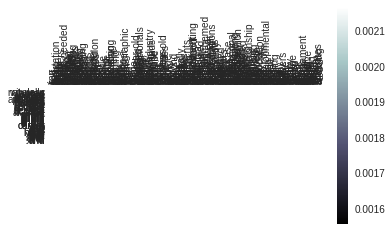

Epoch: 3
input_batches_ref.size()
torch.Size([1324, 5])
input_lengths_ref.size()
[1324, 1016, 717, 517, 215]
input_batches.size()
torch.Size([65, 5])
input_lengths.size()
[65, 65, 65, 65, 65]
sortie Variable containing:
( 0 ,.,.) = 
  0.1835 -0.2821 -0.0261  ...   0.1021 -0.0962 -0.0724
  0.2447  0.0997 -0.2825  ...  -0.2876  0.1549 -0.3266
  0.5145 -0.0128 -0.1849  ...  -0.1512  0.2643 -0.2028
           ...             ⋱             ...          
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000

( 1 ,.,.) = 
  0.0888 -0.4698 -0.4927  ...   0.0114  0.2210  0.3433
 -0.0397 -0.6504 -0.3228  ...   0.1614 -0.0925  0.0395
  0.0146 -0.0569 -0.4609  ...  -0.0954  0.0547  0.3048
           ...             ⋱             ...          
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000

KeyboardInterrupt: ignored

In [31]:
# Begin!
ecs = []
dcs = []
eca = 0
dca = 0
epoch=0
print_loss_total= 0
plot_loss_total= 0
evaluate_every = 1000
plot_every = 20
batch_size=5
encoder_total_optimizer = optim.Adam(Seq2SEq_main_model.encoder.parameters(), lr=learning_rate)
decoder_total_optimizer = optim.Adam(Seq2SEq_main_model.decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
while epoch < n_epochs:
    epoch += 1
    
    print("Epoch: " + str(epoch))

    # Get training data for this cycle
    input_batches, input_lengths, target_batches, target_lengths,target_context, target_pointer, input_letters = random_batch(batch_size,pairs_train, wordtoindex)
    
    # Run the train function
    loss, ec, dc = Seq2SEq_main_model.train_master_piece(
        input_batches, input_lengths,
        encoder_total_optimizer, decoder_total_optimizer,input_letters, reward_predictor
    )
    

    # Keep track of loss
    print_loss_total += loss
    plot_loss_total += loss
    eca += ec
    dca += dc

    if epoch == 2:
        evaluate_randomly()
    
    if epoch % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print_summary = '%s (%d %d%%) %.4f' % (time_since(start, epoch / n_epochs), epoch, epoch / n_epochs * 100, print_loss_avg)
        print(print_summary)
        show_losses(ecs,dcs,plot_losses)
        
    if epoch % evaluate_every == 0:
        evaluate_randomly()

    if epoch % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0
        
        # TODO: Running average helper
        ecs.append(eca / plot_every)
        dcs.append(dca / plot_every)        
        eca = 0
        dca = 0
        plot_loss_total = 0